Griffin Shelor\
8-4-2024

# Homework 7: File I/O and Datetime

In this homework, we will practice our newfound date/time, text parsing, and file I/O skills with real geoscience datasets. The exercise focus on analyzing seismic waveform data from KiK-net, a large array of strong-motion accelerometers in Japan (https://www.kyoshin.bosai.go.jp/). The data we will look at is stored in text files that are convenient enough to open and close with a text editor to look at them, but are not so easy to load into Python. This is where your new text parsing skills will come in handy!


In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
import os

### Q1. Reading in the file.

The file "homework7_kumamoto_NGSH02_UD1.txt" contains waveform information for the April 2016, Kumamoto, Japan earthquake recorded at the station NGSH02. For this problem:

1. Read all the lines in the file into a single list.
2. Print the total number of lines.
3. Make a dictionary called "meta" (empty for now) that we will use to store "metadata" (auxiliary information / descriptive data about a dataset itself) for the waveform in subsequent problems.

In [13]:
## reading in file
kumamoto_file = open('homework7_kumamoto_NGSH02_UD1.txt', 'r')
## reading lines into a single list
kumamoto = kumamoto_file.readlines()

## cloisng file
#kumamoto_file.close()

## printing number of lines
print(len(kumamoto))

## making empty dictionary
meta = {}

1517


### Q2. Compiling meta data.

The first 17 lines in your file (indices 0 through 16 in your list) store metadata (auxiliary information) about the waveform data. We'll parse this data into a dictionary as follows. Note that for all lines, the actual values of the information start at character 18; the characters before just list what the information is.

* Line 0 gives the origin time when the earthquake occurred. Add a new key to your dictionary called "otime" with a value equal to the second part of this line (i.e., start on character 18). Use `pd.to_datetime(...)` to convert this to a `datetime`.

* Lines 1, 2, 3, 4 give the earthquake's latitude, longitude, depth, and magnitude. Store these in your dictionary as floating point numbers with dictionary keys named "qlat", "qlon", "qdep", "qmag". (Again, the information starts at character 18).

* Lines 5, 6, and 7 give the station name, latitude and longitude. Store these in your dictionary as a string, float, and float with keys named "sta", "slat", "slon". For "sta", be sure to strip of the final character (the newline, \n)

* Lines 9 and 10 give the start time of the recording and the sampling rate in Hz. Store these as a pandas `datetime` and a float with keys named "tstart" and "fsamp".

When this is done, use a for loop to iterate over the `items()` in your dictionary, printing each item (key, value pair) on a separate line.

In [14]:
## appending metadata to a dictionary line by line
## creating list of keys
key_list = ["otime", "qlat", "qlon", "qdep", "qmag", "sta", "slat", "slon", "sheight","tstart", "fsamp", "time_dir", "dir", "scalefac", "maxacc", "lastcor", "memo"]

## for loop to iterate over lines, attach line to appropriate key in key_list
for i in range(16):
    row = kumamoto[i]
    line = row[18:]
    if i == 0 or i == 9:
        line_clean = line.replace('\n','')
        meta[key_list[i]] = pd.to_datetime(line_clean)
    elif i == 2 or i == 3 or i == 4 or i == 6 or i == 7:
        line_clean = line.replace('\n','')
        meta[key_list[i]] = float(line_clean)
    elif i == 10:
        line_clean = line.replace('Hz','')
        line_clean = line_clean.replace('\n','')
        meta[key_list[i]] = float(line_clean)
    elif i == 5:
        line_clean = line.replace('\n','')
        meta[key_list[i]] = line_clean
    else:
        line_clean = line.replace('\n','')
        meta[key_list[i]] = line_clean

        
## iterating over items:
for key, val in meta.items():
    print(key, ":", val)

otime : 2016-04-16 01:25:00
qlat : 32.753
qlon : 130.762
qdep : 12.0
qmag : 7.3
sta : NGSH02
slat : 33.2122
slon : 129.7652
sheight : 28
tstart : 2016-04-16 01:25:25
fsamp : 100.0
time_dir : 120
dir : 3
scalefac : 2940(gal)/6170270
maxacc : 9.127
lastcor : 2016/04/16 01:25:10


### Q3. Load the waveform data.

The remaining lines in the file (indices 17 and on in your list of lines) contain the waveform data itself (in digitized units). You will notice on each line there are 8 numbers, and there are hundreds of lines. These lines store a time series of data points, read left to right and top to bottom (a bit like a book). The first 8 data points are on the first line, the next 8 on the next line, and so on.

To create a time series of data points from these lines, do the following:

1. Create an empty list.
2. Loop over the remaining lines in the file starting with line 17.
3. Split each line into 8 numbers.
4. Append each number in sequence as an `int` to your list.

At the end, convert the list into a numpy array and print its length and the first 5 values.

In [15]:
## creating empty list to store integers
int_list = []

for i in range(17, len(kumamoto)):
    row = kumamoto[i]
    row_strlist = row.split()
    for x in range(len(row_strlist)):
        num_int = int(row_strlist[x])
        int_list.append(num_int)

## converting to array
int_array = np.asarray(int_list)
## printing first 5 values
print(int_array[0:5])


[-11218 -11222 -11221 -11219 -11225]


### Q4. Store waveform data in a `DataFrame`

Make an empty `pandas DataFrame` called "wf". Add your seismic data as the first column, and add a second column with a timing array of the same length and the correct sampling rate. The time vector should start at t = 0.0 and have units of seconds.

*Hint*: the time increment between points is equal to `1 / meta["fsamp"]`. This can be used as the interval in `np.arange()`, for example.

In [16]:
## creating dataframe, adding columns
wf = pd.DataFrame()
wf['seismic'] = int_array
wf['time_array'] = np.arange(0.0, 120, 1/meta["fsamp"])

### Q5. Convert your time vector to UTC.

In Q4, you made a time vector with the right sampling rate but starting at a time of 0.0. To convert this to an actual timestamp, do the following:

1. Create a new column in your `DataFrame` equal to `meta["tstart"]` plus a datetime version of your time vector, e.g. `pd.to_timedelta(wf["time"], unit="s")`.
2. Since "tstart" is Japan's time zone, we need to subtract nine hours to convert to the standard UTC. Do this by subtracting `pd.to_timedelta(9, unit="H")` from your new column.

Display your DataFrame with these updates.

In [17]:
## creating tstart column, converting time 
wf["timestamp"] = meta["tstart"] + pd.to_timedelta(wf['time_array'], unit = "s")
wf["timestamp_utc"] = wf["timestamp"] - pd.to_timedelta(9, unit = "H")

## viewing df
wf


,seismic,time_array,timestamp,timestamp_utc
0,-11218,0.00,2016-04-16 01:25:25.000,2016-04-15 16:25:25.000
1,-11222,0.01,2016-04-16 01:25:25.010,2016-04-15 16:25:25.010
2,-11221,0.02,2016-04-16 01:25:25.020,2016-04-15 16:25:25.020
3,-11219,0.03,2016-04-16 01:25:25.030,2016-04-15 16:25:25.030
4,-11225,0.04,2016-04-16 01:25:25.040,2016-04-15 16:25:25.040
...,...,...,...,...
11995,-10920,119.95,2016-04-16 01:27:24.950,2016-04-15 16:27:24.950
11996,-10937,119.96,2016-04-16 01:27:24.960,2016-04-15 16:27:24.960
11997,-10947,119.97,2016-04-16 01:27:24.970,2016-04-15 16:27:24.970
11998,-10951,119.98,2016-04-16 01:27:24.980,2016-04-15 16:27:24.980


### Q6. Plot waveform data.

Plot the time series (time in UTC as the x variable, data as the y-variable). Make the figure have a size of (10,4). Label both axes.

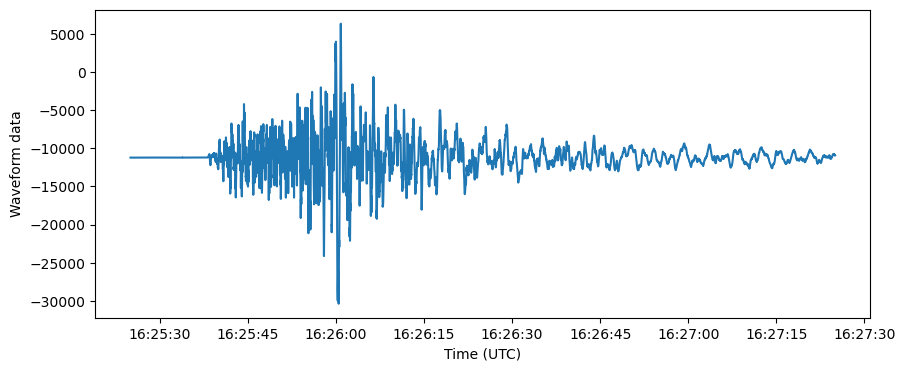

In [18]:
## changing figure size, plotting data
plt.figure(figsize=(10,4))
plt.plot(wf["timestamp_utc"], wf["seismic"])
plt.xlabel("Time (UTC)")
plt.ylabel("Waveform data");


### Q7. Filtering waveform data

So far, we've worked with the raw seismic data as recorded by the seismometer. Often in seismology, we want to filter the data into a specific frequency band to aid visualization or other analysis. The `scipy` package has a nice set of functions in the `signal` module (https://docs.scipy.org/doc/scipy/reference/signal.html) that we can use to do this: 

For example, the cell below calculates the coefficients (`b` and `a`) of a 4-pole Butterworth filter that low passes the data with a corner frequency of 1.0 Hz. Notice how we input the known sampling rate of the data, 100.0 Hz.

In [19]:
from scipy import signal
b, a = signal.butter(4,1.0,"low",output="ba",fs=100.0)

In the cells below, we will compare the original waveform data to a filter version as follows:

* First, compute the mean value of the data array and subtract it from the data (centering the data in this way is a best practice before filtering).
* Next, use the command `signal.filtfilt(b, a, data)` to filter the data (after mean has been removed).
* Then make a single plot with two time series: the raw data (with the mean removed) in black (linewidth of 1), and the filtered data in red (linewidth of 2). Label your axes, and add a legend to your figure.

Hint: see the documentation here https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.filtfilt.html if you get stuck.

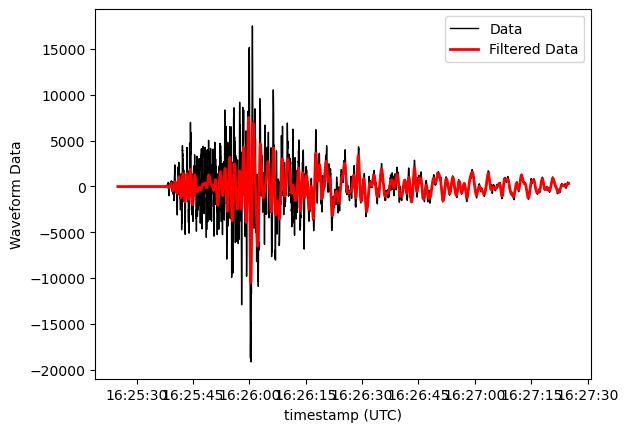

In [20]:
## computing mean of data
data_mean = wf["seismic"].mean()

## subtracting mean from data
seismic_submean = wf["seismic"] - data_mean

## filtering data
y = signal.filtfilt(b, a, seismic_submean)

## plotting data
plt.plot(wf["timestamp_utc"], seismic_submean, color = "black", lw = 1, label = "Data")
plt.plot(wf["timestamp_utc"], y, color = "red", lw = 2, label = "Filtered Data")
plt.xlabel("timestamp (UTC)")
plt.ylabel("Waveform Data")
plt.legend(loc = "best");

### Q8. Design your own filter.

Use `signal.butter(...)` as in the example cell above to create a new filter in a frequency band of your choice. Notice that you can create lowpass, highpass, or bandpass filters by changing the third input argument to `butter` to "low", "high", or "bandpass", respectively. The second input argument controls the corner frequency of the filter (for the bandpass case, you need to pass a list of two corner frequencies instead of a single value).

After you've designed your new filter, apply it to the raw (de-meaned) data and make an analogous plot to the one in Q7. 


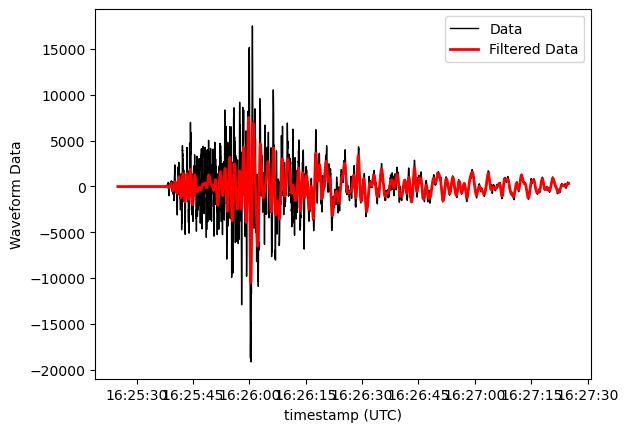

In [21]:
## designing own filter
b_new, a_new = signal.butter(10,2.5,"high",output="ba",fs=100.0)

## computing mean of data
data_mean_new = wf["seismic"].mean()

## subtracting mean from data
seismic_submean_new = wf["seismic"] - data_mean

## filtering data
y_new = signal.filtfilt(b, a, seismic_submean_new)

## plotting data
plt.plot(wf["timestamp_utc"], seismic_submean_new, color = "black", lw = 1, label = "Data")
plt.plot(wf["timestamp_utc"], y_new, color = "red", lw = 2, label = "Filtered Data")
plt.xlabel("timestamp (UTC)")
plt.ylabel("Waveform Data")
plt.legend(loc = "best");

### Please list any other students that you worked with on this assignment

In [22]:
# I worked with the following students: Hannah Potts, Faith Machuca

### To receive credit for this homework, upload both the .ipynb file and a .html version.